In \[181\]:

    #%matplotlib inline

    # import libraries 
    import pandas as pd
    import numpy as np
    from statistics import mean

    #data visualization
    import matplotlib as mpl
    import plotly.graph_objects as go
    import plotly.express as px
    import plotly.offline as pyo
    import plotly.graph_objs as go
    import matplotlib.pyplot as plt 
    from sklearn.metrics import mean_absolute_error
    # ARIMA modelling libraries
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    from statsmodels.tsa.arima.model import ARIMA

    from statsmodels.tsa.stattools import acf, pacf
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    import warnings
    import seaborn as sns
    warnings.simplefilter('ignore', ConvergenceWarning)
    sns.set()

    import scipy
    print(scipy.__version__)

    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from pandas.plotting import autocorrelation_plot
    from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
    import statsmodels.formula.api as smf
    import statsmodels.tsa.api as smt
    import statsmodels.api as sm
    import scipy.stats as scs
    from pandas import Series as Series
    from prophet import Prophet
    from prophet.plot import plot_cross_validation_metric
    from prophet.diagnostics import cross_validation
    from prophet.diagnostics import performance_metrics

    import plotly.io as pio
    pio.renderers.default='notebook'
    # Set notebook mode to work in offline
    pyo.init_notebook_mode()

    1.10.1

In \[182\]:

    def best_fit_slope_and_intercept(xs, ys):
        m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
             ((mean(xs)*mean(xs)) - mean(xs*xs)))
        b = mean(ys) - m*mean(xs)
        
        return m, b

# Temperature<a href="#Temperature" class="anchor-link">¶</a>

In \[183\]:

    # read data sets
    df = pd.read_csv("Environment_Temperature_change_E_All_Data_NOFLAG.csv", encoding='latin-1')
    df_countrycode=pd.read_csv('FAOSTAT_data_11-24-2020.csv')
    df.head()

Out\[183\]:

|     | Area Code | Area        | Months Code | Months   | Element Code | Element            | Unit | Y1961  | Y1962 | Y1963 | ... | Y2010 | Y2011 | Y2012  | Y2013 | Y2014  | Y2015  | Y2016 | Y2017  | Y2018 | Y2019 |
|-----|-----------|-------------|-------------|----------|--------------|--------------------|------|--------|-------|-------|-----|-------|-------|--------|-------|--------|--------|-------|--------|-------|-------|
| 0   | 2         | Afghanistan | 7001        | January  | 7271         | Temperature change | °C   | 0.777  | 0.062 | 2.744 | ... | 3.601 | 1.179 | -0.583 | 1.233 | 1.755  | 1.943  | 3.416 | 1.201  | 1.996 | 2.951 |
| 1   | 2         | Afghanistan | 7001        | January  | 6078         | Standard Deviation | °C   | 1.950  | 1.950 | 1.950 | ... | 1.950 | 1.950 | 1.950  | 1.950 | 1.950  | 1.950  | 1.950 | 1.950  | 1.950 | 1.950 |
| 2   | 2         | Afghanistan | 7002        | February | 7271         | Temperature change | °C   | -1.743 | 2.465 | 3.919 | ... | 1.212 | 0.321 | -3.201 | 1.494 | -3.187 | 2.699  | 2.251 | -0.323 | 2.705 | 0.086 |
| 3   | 2         | Afghanistan | 7002        | February | 6078         | Standard Deviation | °C   | 2.597  | 2.597 | 2.597 | ... | 2.597 | 2.597 | 2.597  | 2.597 | 2.597  | 2.597  | 2.597 | 2.597  | 2.597 | 2.597 |
| 4   | 2         | Afghanistan | 7003        | March    | 7271         | Temperature change | °C   | 0.516  | 1.336 | 0.403 | ... | 3.390 | 0.748 | -0.527 | 2.246 | -0.076 | -0.497 | 2.296 | 0.834  | 4.418 | 0.234 |

5 rows × 66 columns

In \[184\]:

    #1. Renaming
    df.rename(columns = {'Area':'Country Name'},inplace = True)
    df.set_index('Months', inplace=True)
    df.rename({'Dec\x96Jan\x96Feb': 'Winter', 'Mar\x96Apr\x96May': 'Spring', 'Jun\x96Jul\x96Aug':'Summer','Sep\x96Oct\x96Nov':'Fall'}, axis='index',inplace = True)
    df.reset_index(inplace = True)

In \[185\]:

    #2. Filtering 
    df = df[df['Element'] == 'Temperature change']

    #2. Drop unwanted columns from df_countrycode
    df_countrycode.drop(['Country Code','M49 Code','ISO2 Code','Start Year','End Year'],axis=1,inplace=True)
    df_countrycode.rename(columns = {'Country':'Country Name','ISO3 Code':'Country Code'},inplace=True)

    #3. Merging with df to df_country
    df = pd.merge(df, df_countrycode, how='outer', on='Country Name')

    #2. Drop unwanted columns
    df.drop(['Area Code','Months Code','Element Code','Element','Unit'],axis=1,inplace=True)

    #3.Channing dataframe organization
    df = df.melt(id_vars=["Country Code", "Country Name","Months",], var_name="year", value_name="tem_change")
    df["year"] = [i.split("Y")[-1] for i in df.year]

    display(df.head(5))

|     | Country Code | Country Name | Months   | year | tem_change |
|-----|--------------|--------------|----------|------|------------|
| 0   | AFG          | Afghanistan  | January  | 1961 | 0.777      |
| 1   | AFG          | Afghanistan  | February | 1961 | -1.743     |
| 2   | AFG          | Afghanistan  | March    | 1961 | 0.516      |
| 3   | AFG          | Afghanistan  | April    | 1961 | -1.709     |
| 4   | AFG          | Afghanistan  | May      | 1961 | 1.412      |

In \[186\]:

    df0 = df[df['Country Name'] == 'World']
    year_tem_change = df0.groupby(['year'])['tem_change'].mean().to_frame().reset_index()
    #year_tem_change['tem_change_ma'] = year_tem_change['tem_change'].rolling(2).mean()

In \[187\]:

    year_tem_change.head()

Out\[187\]:

|     | year | tem_change |
|-----|------|------------|
| 0   | 1961 | 0.155941   |
| 1   | 1962 | 0.053235   |
| 2   | 1963 | 0.139000   |
| 3   | 1964 | -0.277353  |
| 4   | 1965 | -0.170941  |

In \[188\]:

    m, b = best_fit_slope_and_intercept(pd.to_numeric(year_tem_change['year']), year_tem_change['tem_change'])

    regression_line = []
    for x in pd.to_numeric(year_tem_change['year']):
        regression_line.append((m*x)+b)
        
    year_tem_change['line'] = regression_line

In \[ \]:

     

In \[189\]:

    # Create traces
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = year_tem_change['year'] , y=year_tem_change.tem_change, mode='lines', name='Global temperature'))
    fig.add_trace(go.Scatter(x = year_tem_change['year'] , y=year_tem_change.line, line = dict(color='red', width=1, dash='dash'), name='Trend'))

    # adjusting size of graph, legend place, and background colour
    fig.update_layout(autosize=False, width=1000, height=600, margin=dict(l=50, r=50, b=100, t=100, pad=4), 
        template='seaborn',title='Global Temperature Change (1961 - 2019)',paper_bgcolor="rgb(234, 234, 242)",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    fig.update_xaxes(type='category',title='Years')
    fig.update_yaxes(title='Temperature Change')

    fig.show("notebook")

In \[190\]:

    data = year_tem_change.rename(columns={'tem_change': 'value'})
    data = data.astype({'year':'int'})
    #data = data.drop(columns=['tem_change_ma', 'line'])
    #nd_df = nd_df.iloc[60:]
    #nd_df = nd_df.iloc[:-1]
    data.head()

Out\[190\]:

|     | year | value     | line      |
|-----|------|-----------|-----------|
| 0   | 1961 | 0.155941  | -0.276829 |
| 1   | 1962 | 0.053235  | -0.249188 |
| 2   | 1963 | 0.139000  | -0.221546 |
| 3   | 1964 | -0.277353 | -0.193905 |
| 4   | 1965 | -0.170941 | -0.166264 |

In \[191\]:

    data['year'] = pd.to_datetime(data['year'], format="%Y")
    data.tail()

Out\[191\]:

|     | year       | value    | line     |
|-----|------------|----------|----------|
| 54  | 2015-01-01 | 1.460647 | 1.215799 |
| 55  | 2016-01-01 | 1.626059 | 1.243441 |
| 56  | 2017-01-01 | 1.462353 | 1.271082 |
| 57  | 2018-01-01 | 1.278294 | 1.298723 |
| 58  | 2019-01-01 | 1.510882 | 1.326364 |

In \[192\]:

    ts = data[['year', 'value']].rename(columns={'year':'ds', 'value':'y'})

    ts.columns=['ds','y']
    temp_model = Prophet() 
    temp_model.fit(ts)

    23:54:11 - cmdstanpy - INFO - Chain [1] start processing
    23:54:11 - cmdstanpy - INFO - Chain [1] done processing

Out\[192\]:

    <prophet.forecaster.Prophet at 0x150a6a3b0>

In \[193\]:

    # predict for 1 year in the furure and MS - month start is the frequency
    future = temp_model.make_future_dataframe(periods = 31, freq = 'YS') 
    future.tail()

Out\[193\]:

|     | ds         |
|-----|------------|
| 85  | 2046-01-01 |
| 86  | 2047-01-01 |
| 87  | 2048-01-01 |
| 88  | 2049-01-01 |
| 89  | 2050-01-01 |

In \[194\]:

    # now lets make the forecasts
    forecast = temp_model.predict(future)
    forecast.tail()

Out\[194\]:

|     | ds         | trend    | yhat_lower | yhat_upper | trend_lower | trend_upper | additive_terms | additive_terms_lower | additive_terms_upper | yearly   | yearly_lower | yearly_upper | multiplicative_terms | multiplicative_terms_lower | multiplicative_terms_upper | yhat     |
|-----|------------|----------|------------|------------|-------------|-------------|----------------|----------------------|----------------------|----------|--------------|--------------|----------------------|----------------------------|----------------------------|----------|
| 85  | 2046-01-01 | 1.114602 | 1.863250   | 2.348392   | 1.114404    | 1.114803    | 0.991871       | 0.991871             | 0.991871             | 0.991871 | 0.991871     | 0.991871     | 0.0                  | 0.0                        | 0.0                        | 2.106473 |
| 86  | 2047-01-01 | 1.142289 | 1.877799   | 2.349997   | 1.142081    | 1.142504    | 0.954901       | 0.954901             | 0.954901             | 0.954901 | 0.954901     | 0.954901     | 0.0                  | 0.0                        | 0.0                        | 2.097190 |
| 87  | 2048-01-01 | 1.169976 | 1.828522   | 2.299027   | 1.169754    | 1.170201    | 0.891753       | 0.891753             | 0.891753             | 0.891753 | 0.891753     | 0.891753     | 0.0                  | 0.0                        | 0.0                        | 2.061729 |
| 88  | 2049-01-01 | 1.197739 | 1.963256   | 2.442817   | 1.197502    | 1.197978    | 1.002622       | 1.002622             | 1.002622             | 1.002622 | 1.002622     | 1.002622     | 0.0                  | 0.0                        | 0.0                        | 2.200362 |
| 89  | 2050-01-01 | 1.225427 | 1.970502   | 2.455005   | 1.225176    | 1.225680    | 0.991871       | 0.991871             | 0.991871             | 0.991871 | 0.991871     | 0.991871     | 0.0                  | 0.0                        | 0.0                        | 2.217298 |

In \[195\]:

    temp_model.plot(forecast)

Out\[195\]:

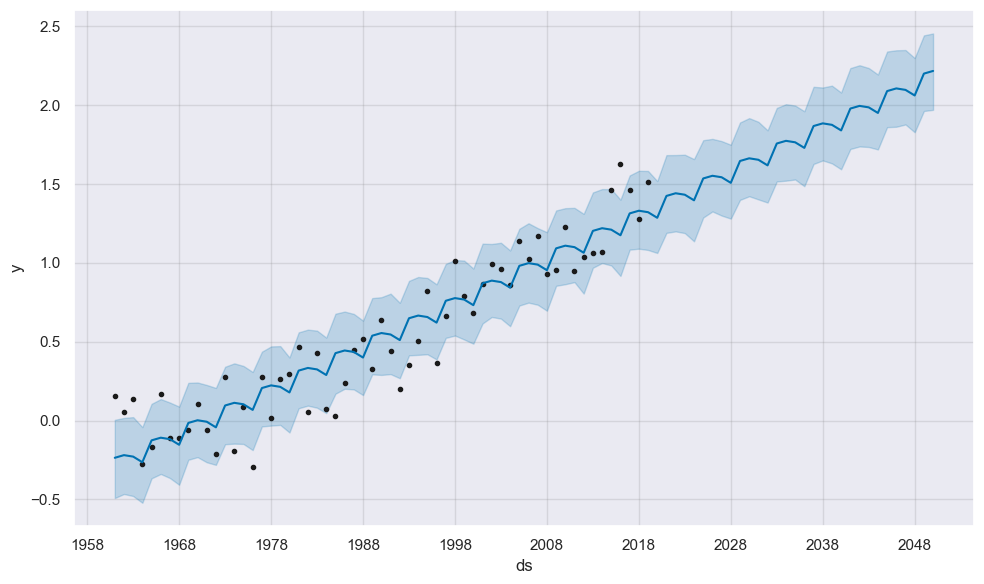

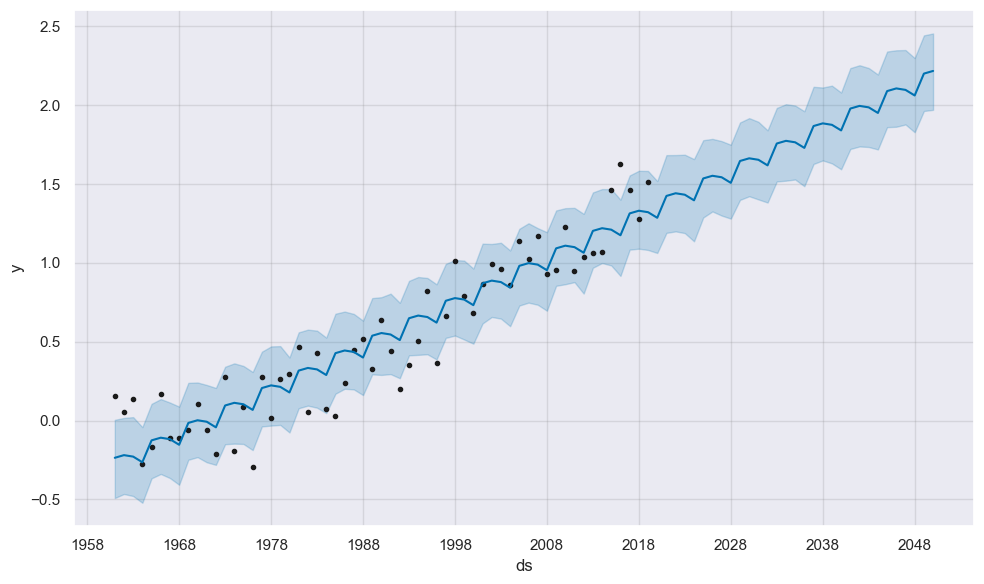

In \[196\]:

    df_cv = cross_validation(temp_model, initial='730 days', period='180 days', horizon = '365 days')

      0%|          | 0/112 [00:00<?, ?it/s]

    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:12 - cmdstanpy - INFO - Chain [1] done processing
    23:54:12 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:13 - cmdstanpy - INFO - Chain [1] done processing
    23:54:13 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:14 - cmdstanpy - INFO - Chain [1] done processing
    23:54:14 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:15 - cmdstanpy - INFO - Chain [1] done processing
    23:54:15 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:16 - cmdstanpy - INFO - Chain [1] done processing
    23:54:16 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:17 - cmdstanpy - INFO - Chain [1] start processing
    23:54:17 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:18 - cmdstanpy - INFO - Chain [1] done processing
    23:54:18 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:19 - cmdstanpy - INFO - Chain [1] done processing
    23:54:19 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:20 - cmdstanpy - INFO - Chain [1] done processing
    23:54:20 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:21 - cmdstanpy - INFO - Chain [1] done processing
    23:54:21 - cmdstanpy - INFO - Chain [1] start processing
    23:54:22 - cmdstanpy - INFO - Chain [1] done processing
    23:54:22 - cmdstanpy - INFO - Chain [1] start processing
    23:54:22 - cmdstanpy - INFO - Chain [1] done processing
    23:54:22 - cmdstanpy - INFO - Chain [1] start processing
    23:54:22 - cmdstanpy - INFO - Chain [1] done processing
    23:54:22 - cmdstanpy - INFO - Chain [1] start processing
    23:54:22 - cmdstanpy - INFO - Chain [1] done processing
    23:54:22 - cmdstanpy - INFO - Chain [1] start processing
    23:54:22 - cmdstanpy - INFO - Chain [1] done processing

In \[197\]:

    df_cv.head()

Out\[197\]:

|     | ds         | yhat      | yhat_lower | yhat_upper | y         | cutoff     |
|-----|------------|-----------|------------|------------|-----------|------------|
| 0   | 1964-01-01 | 0.099364  | 0.046589   | 0.157843   | -0.277353 | 1963-04-20 |
| 1   | 1964-01-01 | 0.099364  | 0.041949   | 0.153759   | -0.277353 | 1963-10-17 |
| 2   | 1965-01-01 | -0.188565 | -0.320097  | -0.057740  | -0.170941 | 1964-04-14 |
| 3   | 1965-01-01 | -0.188565 | -0.324691  | -0.062447  | -0.170941 | 1964-10-11 |
| 4   | 1966-01-01 | -0.290157 | -0.414110  | -0.174580  | 0.171412  | 1965-04-09 |

In \[198\]:

    df_p = performance_metrics(df_cv)
    df_p.head()

Out\[198\]:

|     | horizon | mse      | rmse     | mae      | mape     | mdape    | smape    | coverage |
|-----|---------|----------|----------|----------|----------|----------|----------|----------|
| 0   | 54 days | 0.039432 | 0.198574 | 0.160114 | 1.393686 | 0.452779 | 0.545577 | 0.636364 |
| 1   | 59 days | 0.054683 | 0.233843 | 0.193751 | 1.385720 | 0.452779 | 0.564943 | 0.545455 |
| 2   | 64 days | 0.045442 | 0.213170 | 0.170163 | 0.366776 | 0.389877 | 0.425410 | 0.636364 |
| 3   | 70 days | 0.046164 | 0.214859 | 0.177599 | 0.376121 | 0.389877 | 0.435598 | 0.636364 |
| 4   | 75 days | 0.058282 | 0.241416 | 0.194479 | 0.362258 | 0.389877 | 0.410164 | 0.636364 |

In \[199\]:

    plot_cross_validation_metric(df_cv, metric='mape')

Out\[199\]:

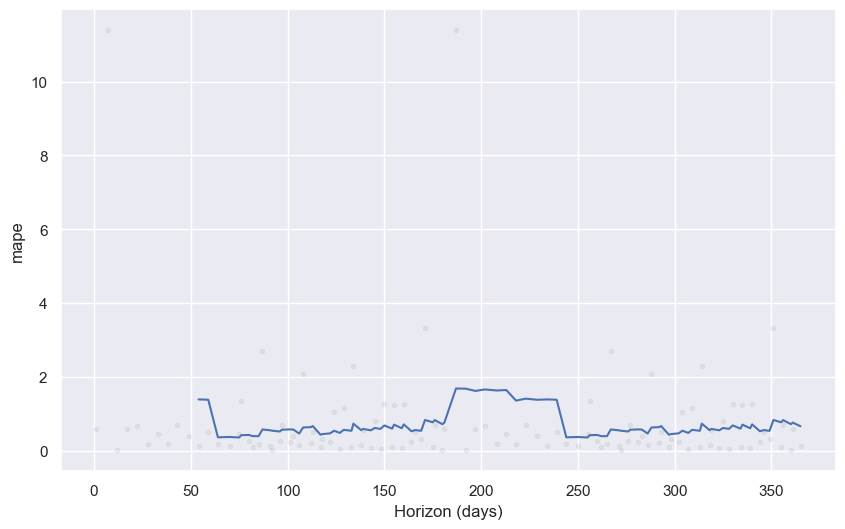

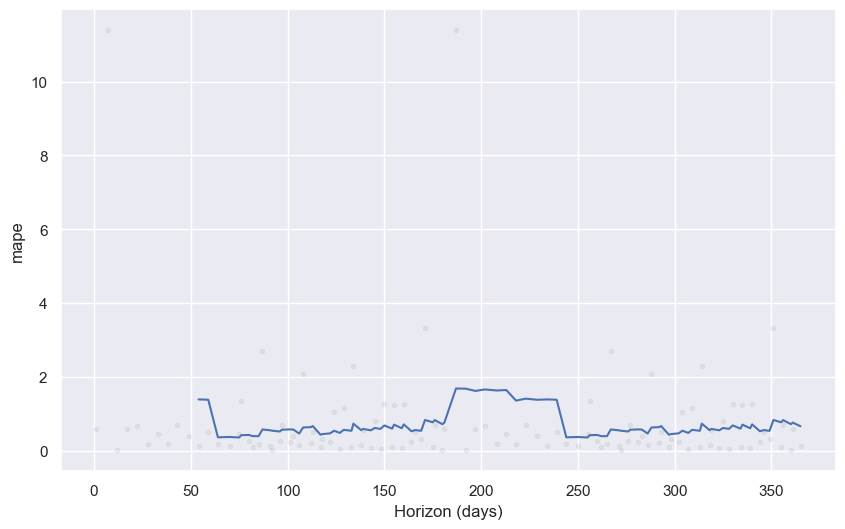

In \[200\]:

    plot_cross_validation_metric(df_cv, metric='rmse')

Out\[200\]:

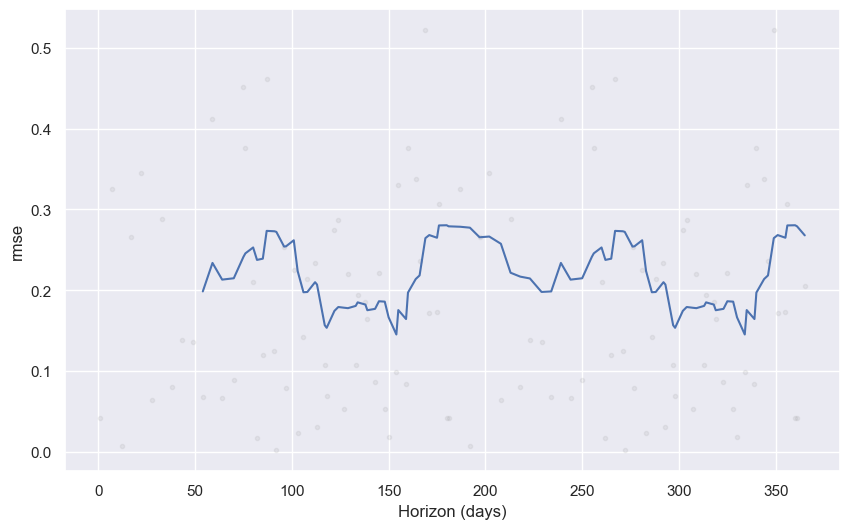

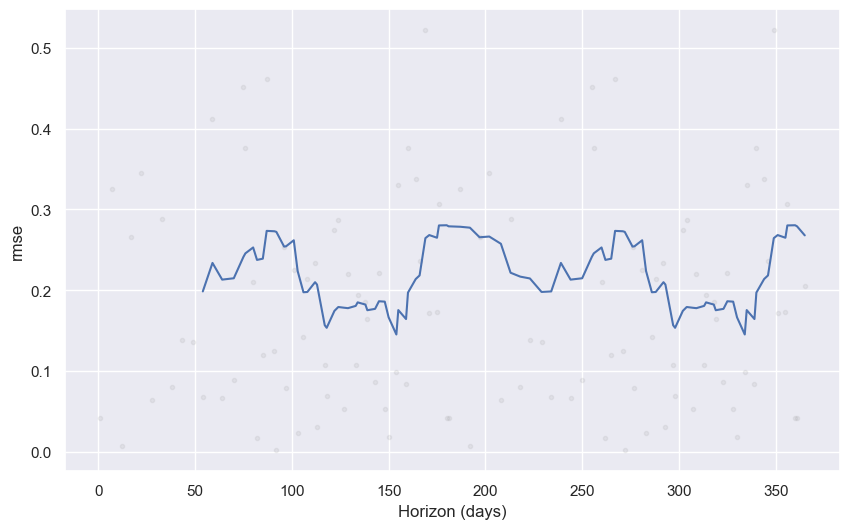

In \[201\]:

    plot_cross_validation_metric(df_cv, metric='mae')

Out\[201\]:

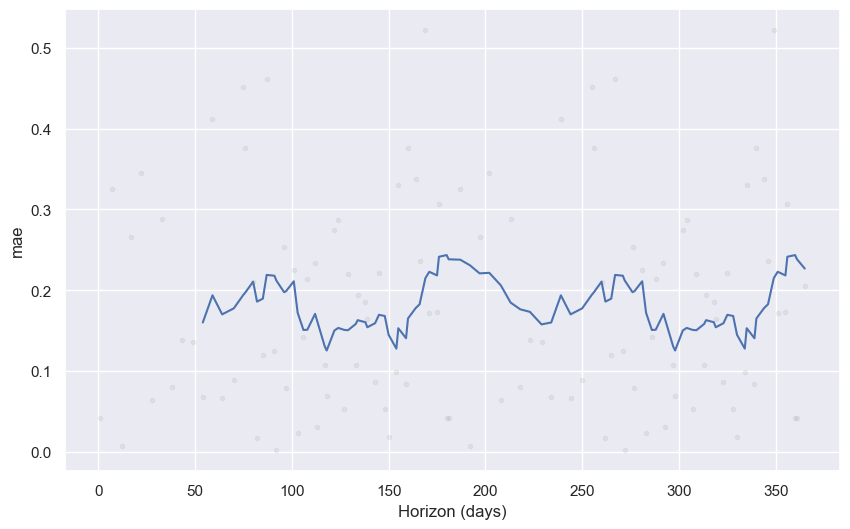

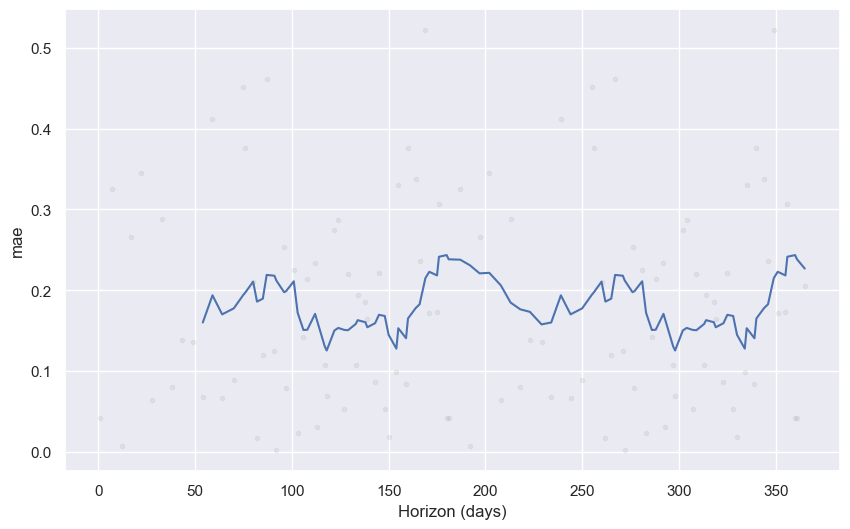

In \[ \]:

     

In \[ \]:

     

# Natural Disasters<a href="#Natural-Disasters" class="anchor-link">¶</a>

In \[202\]:

    nd = pd.read_csv('EMDAT_1900-2021_NatDis.csv')
    nd.head()

Out\[202\]:

|     | Dis No        | Year | Seq  | Disaster Group | Disaster Subgroup | Disaster Type     | Disaster Subtype | Disaster Subsubtype | Event Name  | Entry Criteria | ... | End Day | Total Deaths | No Injured | No Affected | No Homeless | Total Affected | Reconstruction Costs ('000 US\$) | Insured Damages ('000 US\$) | Total Damages ('000 US\$) | CPI      |
|-----|---------------|------|------|----------------|-------------------|-------------------|------------------|---------------------|-------------|----------------|-----|---------|--------------|------------|-------------|-------------|----------------|----------------------------------|-----------------------------|---------------------------|----------|
| 0   | 1900-9002-CPV | 1900 | 9002 | Natural        | Climatological    | Drought           | Drought          | NaN                 | NaN         | NaN            | ... | NaN     | 11000.0      | NaN        | NaN         | NaN         | NaN            | NaN                              | NaN                         | NaN                       | 3.261389 |
| 1   | 1900-9001-IND | 1900 | 9001 | Natural        | Climatological    | Drought           | Drought          | NaN                 | NaN         | NaN            | ... | NaN     | 1250000.0    | NaN        | NaN         | NaN         | NaN            | NaN                              | NaN                         | NaN                       | 3.261389 |
| 2   | 1902-0012-GTM | 1902 | 12   | Natural        | Geophysical       | Earthquake        | Ground movement  | NaN                 | NaN         | Kill           | ... | 18.0    | 2000.0       | NaN        | NaN         | NaN         | NaN            | NaN                              | NaN                         | 25000.0                   | 3.391845 |
| 3   | 1902-0003-GTM | 1902 | 3    | Natural        | Geophysical       | Volcanic activity | Ash fall         | NaN                 | Santa Maria | Kill           | ... | 8.0     | 1000.0       | NaN        | NaN         | NaN         | NaN            | NaN                              | NaN                         | NaN                       | 3.391845 |
| 4   | 1902-0010-GTM | 1902 | 10   | Natural        | Geophysical       | Volcanic activity | Ash fall         | NaN                 | Santa Maria | Kill           | ... | 24.0    | 6000.0       | NaN        | NaN         | NaN         | NaN            | NaN                              | NaN                         | NaN                       | 3.391845 |

5 rows × 43 columns

In \[203\]:

    nd_general = nd.loc[:,['Year','Disaster Subgroup','Disaster Type','Total Deaths','Total Affected']]
    nd_general = nd_general[nd_general['Disaster Subgroup'] != 'Extra-terrestrial']
    nd_general.head()

Out\[203\]:

|     | Year | Disaster Subgroup | Disaster Type     | Total Deaths | Total Affected |
|-----|------|-------------------|-------------------|--------------|----------------|
| 0   | 1900 | Climatological    | Drought           | 11000.0      | NaN            |
| 1   | 1900 | Climatological    | Drought           | 1250000.0    | NaN            |
| 2   | 1902 | Geophysical       | Earthquake        | 2000.0       | NaN            |
| 3   | 1902 | Geophysical       | Volcanic activity | 1000.0       | NaN            |
| 4   | 1902 | Geophysical       | Volcanic activity | 6000.0       | NaN            |

In \[204\]:

    #Plot 'Number of Disasters Recorded by Year'
    nd_general_count = nd_general.groupby(['Year',]).agg({'Disaster Type':'count',})
    nd_general_count = nd_general_count.reset_index()
    nd_general_count.head()

Out\[204\]:

|     | Year | Disaster Type |
|-----|------|---------------|
| 0   | 1900 | 7             |
| 1   | 1901 | 2             |
| 2   | 1902 | 10            |
| 3   | 1903 | 12            |
| 4   | 1904 | 4             |

In \[205\]:

    fig = px.bar(nd_general_count, x="Year", y='Disaster Type',text='Disaster Type' , title="Number of Disasters Recorded by Year")
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    # adjusting size of graph, legend place, and background colour
    fig.update_layout(autosize=False, width=1000, height=600, margin=dict(l=50, r=50, b=100, t=100, pad=4),
        template='seaborn', paper_bgcolor="rgb(234, 234, 242)",
        legend=dict(orientation="v", yanchor="bottom", y=0.3, xanchor="left", x=1.02
    ))

In \[206\]:

    graph_subgroups = nd.groupby(['Disaster Subgroup','Disaster Type']).size().to_frame('Number of disasters').reset_index()
    graph_subgroups.sort_values('Number of disasters',ascending=False, inplace=True)
    graph_subgroups.head()

Out\[206\]:

|     | Disaster Subgroup | Disaster Type | Number of disasters |
|-----|-------------------|---------------|---------------------|
| 10  | Hydrological      | Flood         | 5399                |
| 14  | Meteorological    | Storm         | 4420                |
| 7   | Geophysical       | Earthquake    | 1528                |
| 1   | Biological        | Epidemic      | 1496                |
| 11  | Hydrological      | Landslide     | 767                 |

In \[207\]:

    fig = px.bar(graph_subgroups, x="Disaster Type", y='Number of disasters',text='Number of disasters' , title="Number of Disasters Recorded by Year")
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    # adjusting size of graph, legend place, and background colour
    fig.update_layout(autosize=False, width=1000, height=600, margin=dict(l=50, r=50, b=100, t=100, pad=4),
        template='seaborn', paper_bgcolor="rgb(234, 234, 242)",
        legend=dict(orientation="v", yanchor="bottom", y=0.3, xanchor="left", x=1.02
    ))

In \[208\]:

    nd_df = nd_general_count.rename(columns={'Year': 'year', 'Disaster Type': 'value'})
    nd_df = nd_df.iloc[60:]
    nd_df = nd_df.iloc[:-1]
    nd_df.tail()

Out\[208\]:

|     | year | value |
|-----|------|-------|
| 116 | 2016 | 349   |
| 117 | 2017 | 367   |
| 118 | 2018 | 336   |
| 119 | 2019 | 443   |
| 120 | 2020 | 397   |

In \[209\]:

    nd_df['year'] = pd.to_datetime(nd_df['year'], format="%Y")

    ts = nd_df[['year', 'value']].rename(columns={'year':'ds', 'value':'y'})

    ts.columns=['ds','y']
    nd_model = Prophet() 
    nd_model.fit(ts)

    23:54:23 - cmdstanpy - INFO - Chain [1] start processing
    23:54:23 - cmdstanpy - INFO - Chain [1] done processing

Out\[209\]:

    <prophet.forecaster.Prophet at 0x1368d9600>

In \[210\]:

    # predict for 1 year in the furure and MS - month start is the frequency
    future = nd_model.make_future_dataframe(periods = 30, freq = 'YS') 
    future.tail()

Out\[210\]:

|     | ds         |
|-----|------------|
| 86  | 2046-01-01 |
| 87  | 2047-01-01 |
| 88  | 2048-01-01 |
| 89  | 2049-01-01 |
| 90  | 2050-01-01 |

In \[211\]:

    # now lets make the forecasts
    forecast = nd_model.predict(future)
    forecast.tail()

Out\[211\]:

|     | ds         | trend      | yhat_lower | yhat_upper | trend_lower | trend_upper | additive_terms | additive_terms_lower | additive_terms_upper | yearly     | yearly_lower | yearly_upper | multiplicative_terms | multiplicative_terms_lower | multiplicative_terms_upper | yhat       |
|-----|------------|------------|------------|------------|-------------|-------------|----------------|----------------------|----------------------|------------|--------------|--------------|----------------------|----------------------------|----------------------------|------------|
| 86  | 2046-01-01 | 565.568145 | 602.206726 | 755.202189 | 565.517439  | 565.626925  | 109.491026     | 109.491026           | 109.491026           | 109.491026 | 109.491026   | 109.491026   | 0.0                  | 0.0                        | 0.0                        | 675.059171 |
| 87  | 2047-01-01 | 573.211869 | 597.407547 | 756.121482 | 573.157630  | 573.273745  | 107.878859     | 107.878859           | 107.878859           | 107.878859 | 107.878859   | 107.878859   | 0.0                  | 0.0                        | 0.0                        | 681.090728 |
| 88  | 2048-01-01 | 580.855593 | 611.531398 | 757.500225 | 580.798536  | 580.921735  | 104.258946     | 104.258946           | 104.258946           | 104.258946 | 104.258946   | 104.258946   | 0.0                  | 0.0                        | 0.0                        | 685.114539 |
| 89  | 2049-01-01 | 588.520259 | 618.307996 | 774.542108 | 588.459951  | 588.590299  | 109.093394     | 109.093394           | 109.093394           | 109.093394 | 109.093394   | 109.093394   | 0.0                  | 0.0                        | 0.0                        | 697.613653 |
| 90  | 2050-01-01 | 596.163982 | 624.169292 | 787.526847 | 596.100177  | 596.237936  | 109.491026     | 109.491026           | 109.491026           | 109.491026 | 109.491026   | 109.491026   | 0.0                  | 0.0                        | 0.0                        | 705.655009 |

In \[212\]:

    nd_model.plot(forecast)

Out\[212\]:

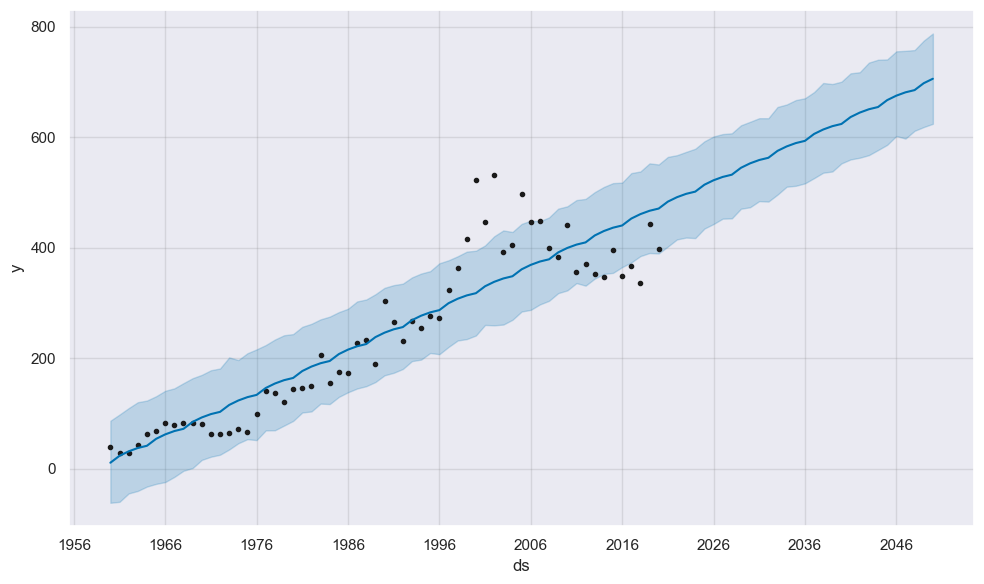

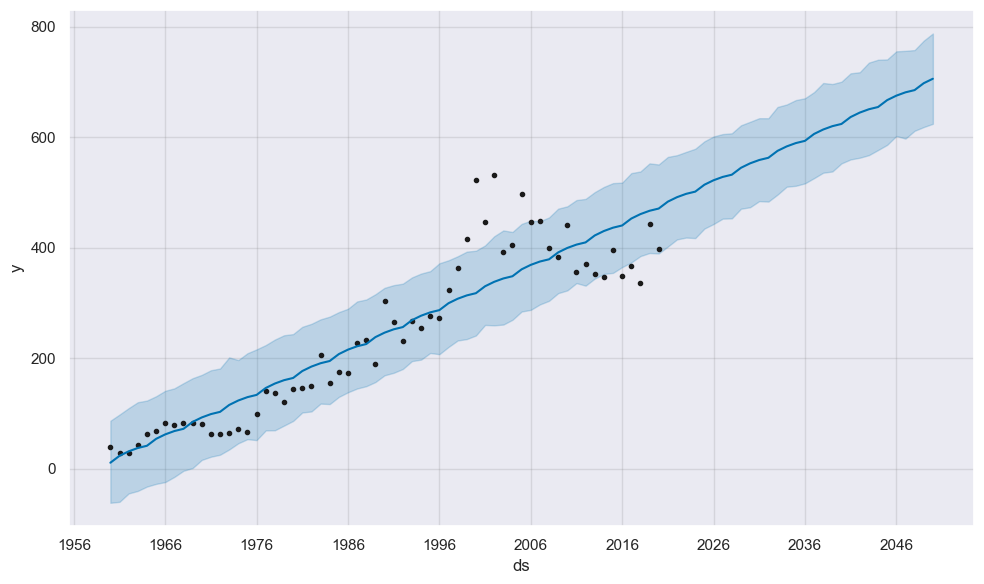

In \[213\]:

    df_cv = cross_validation(nd_model, initial='730 days', period='180 day', horizon = '365 days')

      0%|          | 0/116 [00:00<?, ?it/s]

    23:54:24 - cmdstanpy - INFO - Chain [1] start processing
    23:54:26 - cmdstanpy - INFO - Chain [1] done processing
    23:54:26 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:28 - cmdstanpy - INFO - Chain [1] done processing
    23:54:28 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:29 - cmdstanpy - INFO - Chain [1] done processing
    23:54:29 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:30 - cmdstanpy - INFO - Chain [1] done processing
    23:54:30 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:31 - cmdstanpy - INFO - Chain [1] done processing
    23:54:31 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:32 - cmdstanpy - INFO - Chain [1] done processing
    23:54:32 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:33 - cmdstanpy - INFO - Chain [1] done processing
    23:54:33 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:34 - cmdstanpy - INFO - Chain [1] done processing
    23:54:34 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:35 - cmdstanpy - INFO - Chain [1] start processing
    23:54:35 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:36 - cmdstanpy - INFO - Chain [1] start processing
    23:54:36 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:37 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:37 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:37 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:37 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:37 - cmdstanpy - INFO - Chain [1] done processing
    23:54:37 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:38 - cmdstanpy - INFO - Chain [1] done processing
    23:54:38 - cmdstanpy - INFO - Chain [1] start processing
    23:54:39 - cmdstanpy - INFO - Chain [1] done processing
    23:54:39 - cmdstanpy - INFO - Chain [1] start processing
    23:54:39 - cmdstanpy - INFO - Chain [1] done processing
    23:54:39 - cmdstanpy - INFO - Chain [1] start processing
    23:54:39 - cmdstanpy - INFO - Chain [1] done processing
    23:54:39 - cmdstanpy - INFO - Chain [1] start processing
    23:54:39 - cmdstanpy - INFO - Chain [1] done processing
    23:54:39 - cmdstanpy - INFO - Chain [1] start processing
    23:54:40 - cmdstanpy - INFO - Chain [1] done processing
    23:54:40 - cmdstanpy - INFO - Chain [1] start processing
    23:54:40 - cmdstanpy - INFO - Chain [1] done processing
    23:54:40 - cmdstanpy - INFO - Chain [1] start processing
    23:54:40 - cmdstanpy - INFO - Chain [1] done processing
    23:54:40 - cmdstanpy - INFO - Chain [1] start processing
    23:54:40 - cmdstanpy - INFO - Chain [1] done processing

In \[214\]:

    df_cv.tail()

Out\[214\]:

|     | ds         | yhat       | yhat_lower | yhat_upper | y   | cutoff     |
|-----|------------|------------|------------|------------|-----|------------|
| 111 | 2018-01-01 | 477.275960 | 395.544862 | 554.965802 | 336 | 2017-01-11 |
| 112 | 2018-01-01 | 477.275960 | 401.431838 | 551.607503 | 336 | 2017-07-10 |
| 113 | 2019-01-01 | 475.120893 | 395.507834 | 554.179964 | 443 | 2018-01-06 |
| 114 | 2019-01-01 | 475.120893 | 397.922470 | 542.395044 | 443 | 2018-07-05 |
| 115 | 2020-01-01 | 479.046162 | 399.273109 | 555.727385 | 397 | 2019-01-01 |

In \[215\]:

    df_p = performance_metrics(df_cv)
    df_p.head()

Out\[215\]:

|     | horizon | mse         | rmse      | mae       | mape     | mdape    | smape    | coverage |
|-----|---------|-------------|-----------|-----------|----------|----------|----------|----------|
| 0   | 54 days | 1537.324838 | 39.208734 | 27.832534 | 0.109518 | 0.058043 | 0.121258 | 0.636364 |
| 1   | 59 days | 1529.255427 | 39.105696 | 27.254227 | 0.105506 | 0.057014 | 0.117096 | 0.636364 |
| 2   | 65 days | 1738.022563 | 41.689598 | 31.364763 | 0.117560 | 0.098939 | 0.130224 | 0.545455 |
| 3   | 66 days | 1524.283067 | 39.042068 | 28.114058 | 0.128219 | 0.098939 | 0.144690 | 0.545455 |
| 4   | 70 days | 1803.177816 | 42.463841 | 30.520698 | 0.128677 | 0.098939 | 0.145251 | 0.545455 |

In \[216\]:

    plot_cross_validation_metric(df_cv, metric='mae')

Out\[216\]:

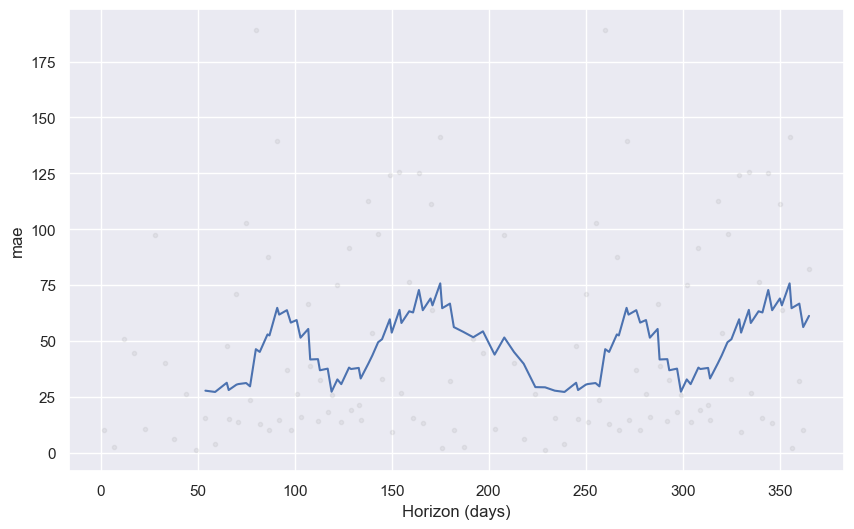

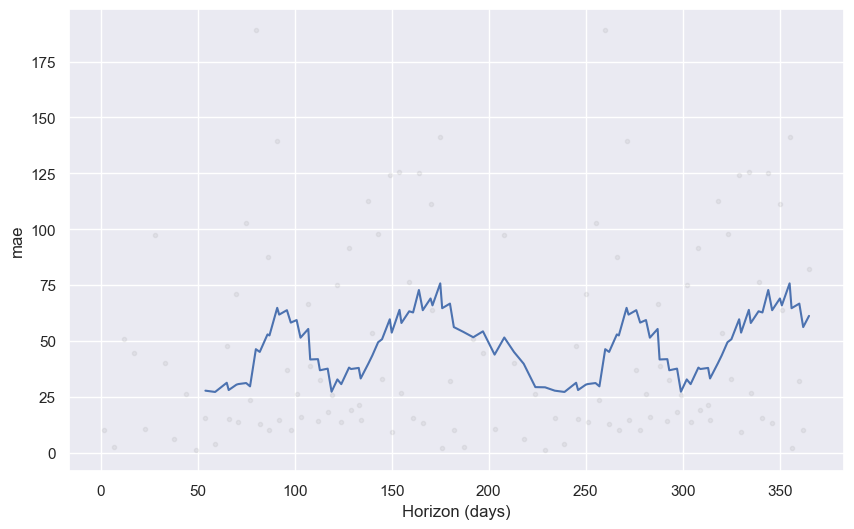

In \[217\]:

    plot_cross_validation_metric(df_cv, metric='mape')

Out\[217\]:

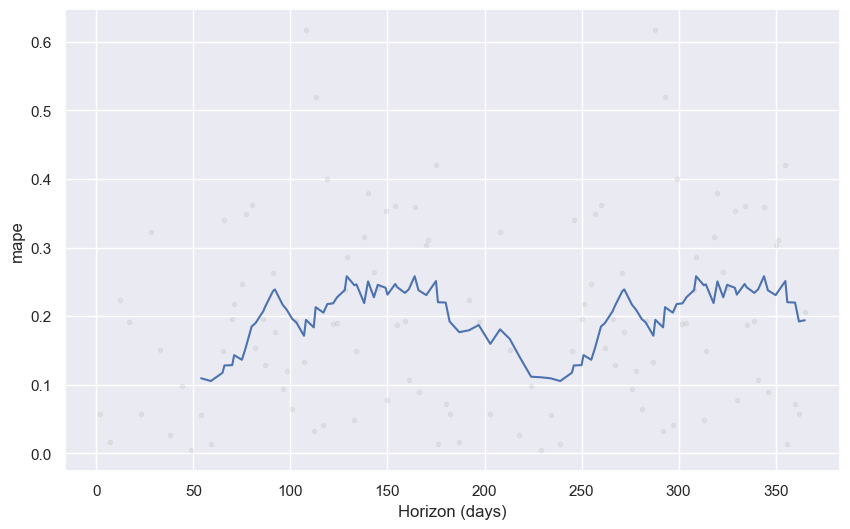

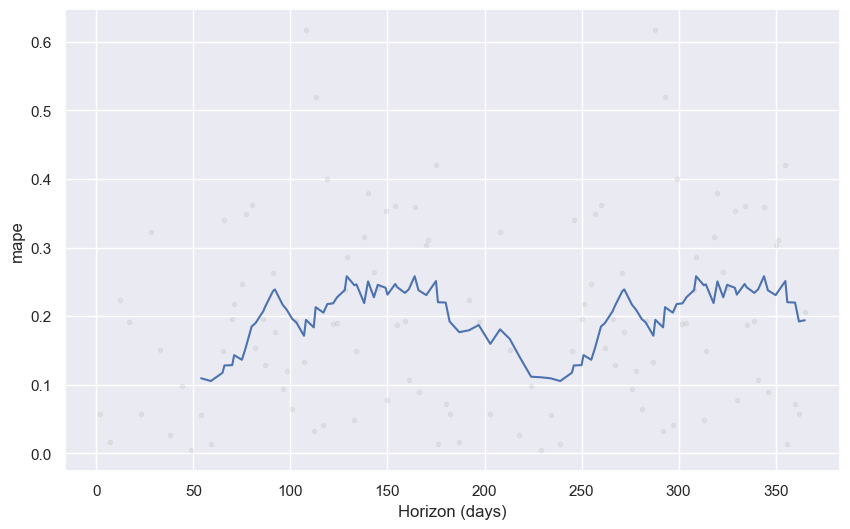

## <a href="#" class="anchor-link">¶</a>

In \[218\]:

    plot_cross_validation_metric(df_cv, metric='rmse')

Out\[218\]:

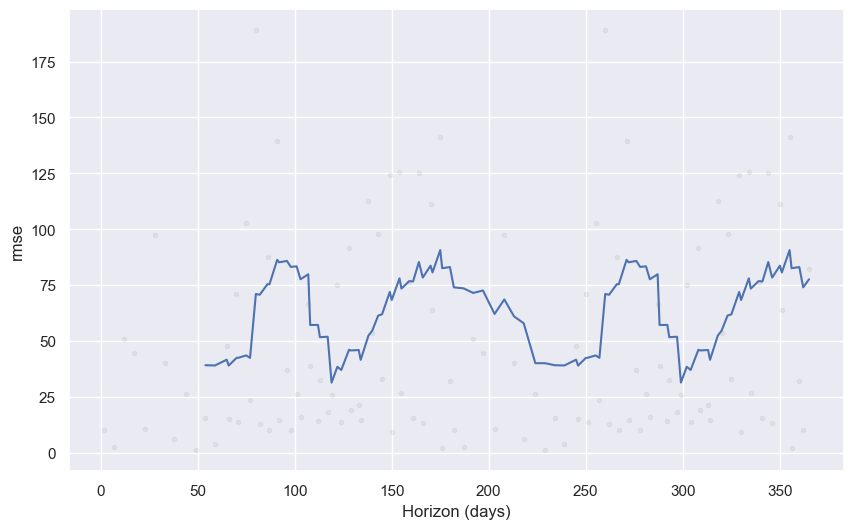

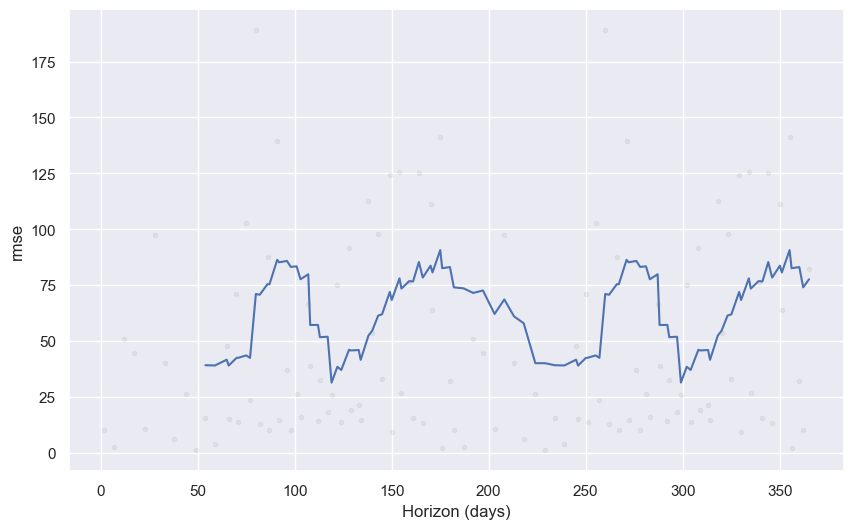

In \[ \]:

     

In \[ \]:

     

# CO2 Emissions<a href="#CO2-Emissions" class="anchor-link">¶</a>

In \[219\]:

    co2 = pd.read_csv('co2_emissions_kt_by_country.csv')
    co2.head()

Out\[219\]:

|     | country_code | country_name | year | value     |
|-----|--------------|--------------|------|-----------|
| 0   | ABW          | Aruba        | 1960 | 11092.675 |
| 1   | ABW          | Aruba        | 1961 | 11576.719 |
| 2   | ABW          | Aruba        | 1962 | 12713.489 |
| 3   | ABW          | Aruba        | 1963 | 12178.107 |
| 4   | ABW          | Aruba        | 1964 | 11840.743 |

In \[220\]:

    co2_world = co2[co2.country_name == 'World']
    co2_sum = co2_world.groupby(['year'])['value'].sum().to_frame().reset_index()

In \[221\]:

    m, b = best_fit_slope_and_intercept(pd.to_numeric(co2_sum['year']), co2_sum['value'])

    regression_line = []
    for x in pd.to_numeric(co2_sum['year']):
        regression_line.append((m*x)+b)
        
    co2_sum['line'] = regression_line

In \[222\]:

    # Create traces
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = co2_sum['year'] , y=co2_sum.value, mode='lines', name='Global CO2'))
    fig.add_trace(go.Scatter(x = co2_sum['year'] , y=co2_sum.line, line = dict(color='red', width=1, dash='dash'), name='Trend'))

    # adjusting size of graph, legend place, and background colour
    fig.update_layout(autosize=False, width=1000, height=600, margin=dict(l=50, r=50, b=100, t=100, pad=4),
        template='seaborn', title='Global CO2 Emissions', paper_bgcolor="rgb(234, 234, 242)",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1
    ))
    fig.update_xaxes(type='category',title='Years')
    fig.update_yaxes(title='CO2 Level (kiloton)')

    fig.show('notebook')

In \[223\]:

    co2_data = co2.loc[co2['country_name']=='World']
    co2_data.tail()

Out\[223\]:

|       | country_code | country_name | year | value        |
|-------|--------------|--------------|------|--------------|
| 13647 | WLD          | World        | 2015 | 3.299554e+07 |
| 13648 | WLD          | World        | 2016 | 3.301856e+07 |
| 13649 | WLD          | World        | 2017 | 3.351454e+07 |
| 13650 | WLD          | World        | 2018 | 3.428935e+07 |
| 13651 | WLD          | World        | 2019 | 3.434401e+07 |

In \[224\]:

    co2_data['year'] = pd.to_datetime(co2_data['year'], format="%Y")

    ts = co2_data[['year', 'value']].rename(columns={'year':'ds', 'value':'y'})

    ts.columns=['ds','y']
    co2_model = Prophet() 
    co2_model.fit(ts)

    /var/folders/32/vy8ww6fn78b20w6z3gzqr10h0000gn/T/ipykernel_61503/3438402208.py:1: SettingWithCopyWarning:


    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

    23:54:41 - cmdstanpy - INFO - Chain [1] start processing
    23:54:41 - cmdstanpy - INFO - Chain [1] done processing

Out\[224\]:

    <prophet.forecaster.Prophet at 0x1369213c0>

In \[225\]:

    # predict for 1 year in the furure and MS - month start is the frequency
    future = co2_model.make_future_dataframe(periods = 31, freq = 'YS') 
    future.tail()

Out\[225\]:

|     | ds         |
|-----|------------|
| 86  | 2046-01-01 |
| 87  | 2047-01-01 |
| 88  | 2048-01-01 |
| 89  | 2049-01-01 |
| 90  | 2050-01-01 |

In \[226\]:

    # now lets make the forecasts
    forecast = co2_model.predict(future)
    forecast.tail()

Out\[226\]:

|     | ds         | trend        | yhat_lower   | yhat_upper   | trend_lower  | trend_upper  | additive_terms | additive_terms_lower | additive_terms_upper | yearly       | yearly_lower | yearly_upper | multiplicative_terms | multiplicative_terms_lower | multiplicative_terms_upper | yhat         |
|-----|------------|--------------|--------------|--------------|--------------|--------------|----------------|----------------------|----------------------|--------------|--------------|--------------|----------------------|----------------------------|----------------------------|--------------|
| 86  | 2046-01-01 | 5.092541e+07 | 4.860649e+07 | 5.498826e+07 | 4.807249e+07 | 5.401286e+07 | 8.605131e+05   | 8.605131e+05         | 8.605131e+05         | 8.605131e+05 | 8.605131e+05 | 8.605131e+05 | 0.0                  | 0.0                        | 0.0                        | 5.178592e+07 |
| 87  | 2047-01-01 | 5.153086e+07 | 4.926466e+07 | 5.580849e+07 | 4.844704e+07 | 5.478895e+07 | 8.740582e+05   | 8.740582e+05         | 8.740582e+05         | 8.740582e+05 | 8.740582e+05 | 8.740582e+05 | 0.0                  | 0.0                        | 0.0                        | 5.240492e+07 |
| 88  | 2048-01-01 | 5.213632e+07 | 5.001630e+07 | 5.673494e+07 | 4.884518e+07 | 5.557742e+07 | 1.047867e+06   | 1.047867e+06         | 1.047867e+06         | 1.047867e+06 | 1.047867e+06 | 1.047867e+06 | 0.0                  | 0.0                        | 0.0                        | 5.318419e+07 |
| 89  | 2049-01-01 | 5.274343e+07 | 5.024368e+07 | 5.736323e+07 | 4.925669e+07 | 5.631729e+07 | 1.007253e+06   | 1.007253e+06         | 1.007253e+06         | 1.007253e+06 | 1.007253e+06 | 1.007253e+06 | 0.0                  | 0.0                        | 0.0                        | 5.375069e+07 |
| 90  | 2050-01-01 | 5.334889e+07 | 5.051709e+07 | 5.795179e+07 | 4.965528e+07 | 5.711469e+07 | 8.605131e+05   | 8.605131e+05         | 8.605131e+05         | 8.605131e+05 | 8.605131e+05 | 8.605131e+05 | 0.0                  | 0.0                        | 0.0                        | 5.420940e+07 |

In \[227\]:

    co2_model.plot(forecast)

Out\[227\]:

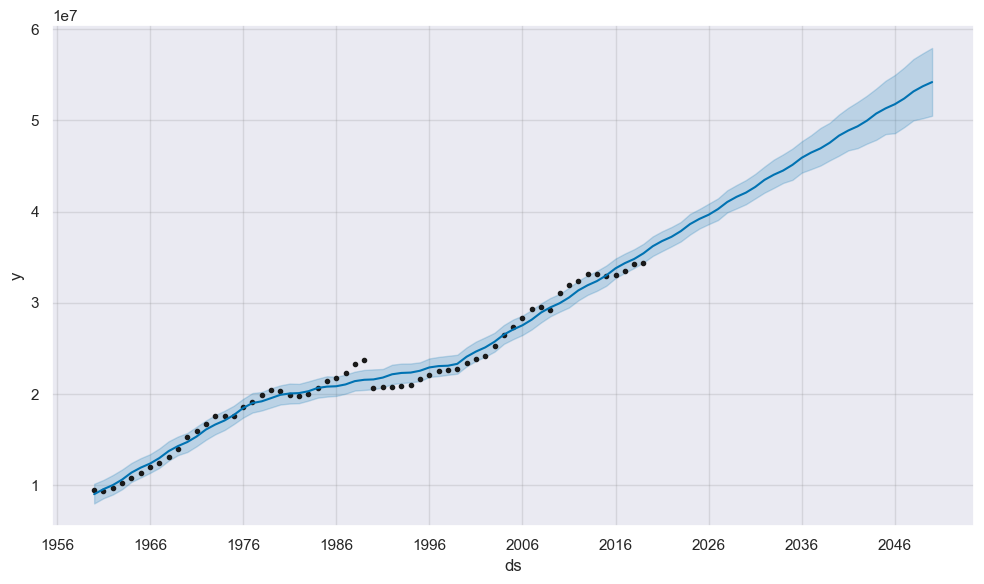

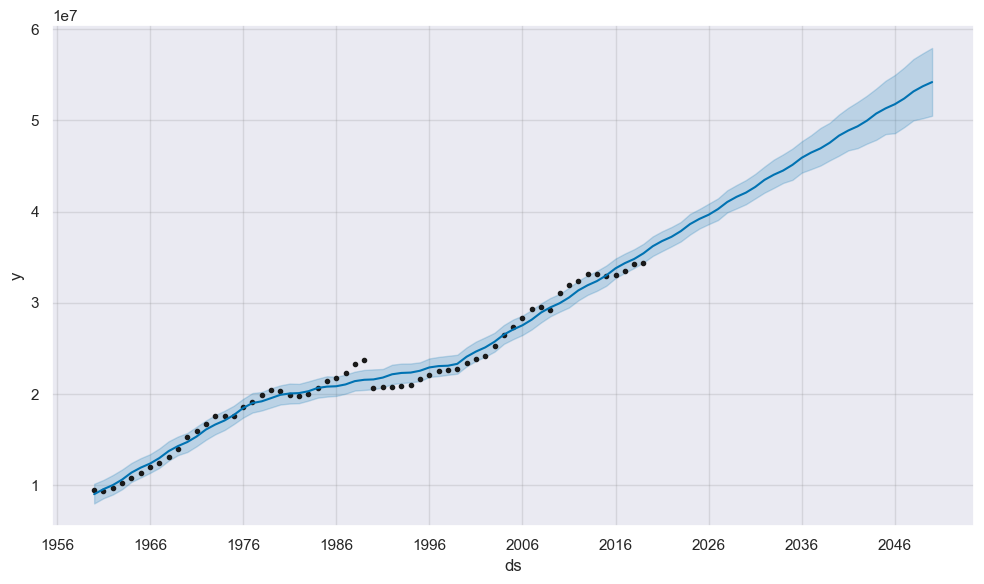

In \[228\]:

    df_cv = cross_validation(co2_model, initial='730 days', period='180 days', horizon = '365 days')

      0%|          | 0/114 [00:00<?, ?it/s]

    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:42 - cmdstanpy - INFO - Chain [1] done processing
    23:54:42 - cmdstanpy - INFO - Chain [1] start processing
    23:54:45 - cmdstanpy - INFO - Chain [1] done processing
    23:54:45 - cmdstanpy - INFO - Chain [1] start processing
    23:54:47 - cmdstanpy - INFO - Chain [1] done processing
    23:54:47 - cmdstanpy - INFO - Chain [1] start processing
    23:54:50 - cmdstanpy - INFO - Chain [1] done processing
    23:54:50 - cmdstanpy - INFO - Chain [1] start processing
    23:54:52 - cmdstanpy - INFO - Chain [1] done processing
    23:54:52 - cmdstanpy - INFO - Chain [1] start processing
    23:54:52 - cmdstanpy - INFO - Chain [1] done processing
    23:54:52 - cmdstanpy - INFO - Chain [1] start processing
    23:54:52 - cmdstanpy - INFO - Chain [1] done processing
    23:54:52 - cmdstanpy - INFO - Chain [1] start processing
    23:54:52 - cmdstanpy - INFO - Chain [1] done processing
    23:54:52 - cmdstanpy - INFO - Chain [1] start processing
    23:54:53 - cmdstanpy - INFO - Chain [1] done processing
    23:54:53 - cmdstanpy - INFO - Chain [1] start processing
    23:54:56 - cmdstanpy - INFO - Chain [1] done processing
    23:54:56 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:54:59 - cmdstanpy - INFO - Chain [1] start processing
    23:54:59 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:00 - cmdstanpy - INFO - Chain [1] done processing
    23:55:00 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:01 - cmdstanpy - INFO - Chain [1] done processing
    23:55:01 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:02 - cmdstanpy - INFO - Chain [1] done processing
    23:55:02 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:03 - cmdstanpy - INFO - Chain [1] done processing
    23:55:03 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:04 - cmdstanpy - INFO - Chain [1] done processing
    23:55:04 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:05 - cmdstanpy - INFO - Chain [1] done processing
    23:55:05 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:06 - cmdstanpy - INFO - Chain [1] done processing
    23:55:06 - cmdstanpy - INFO - Chain [1] start processing
    23:55:07 - cmdstanpy - INFO - Chain [1] done processing
    23:55:07 - cmdstanpy - INFO - Chain [1] start processing
    23:55:07 - cmdstanpy - INFO - Chain [1] done processing
    23:55:07 - cmdstanpy - INFO - Chain [1] start processing
    23:55:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:03 - cmdstanpy - INFO - Chain [1] start processing
    00:09:03 - cmdstanpy - INFO - Chain [1] done processing
    00:09:03 - cmdstanpy - INFO - Chain [1] start processing
    00:09:04 - cmdstanpy - INFO - Chain [1] done processing
    00:09:04 - cmdstanpy - INFO - Chain [1] start processing
    00:09:04 - cmdstanpy - INFO - Chain [1] done processing
    00:09:04 - cmdstanpy - INFO - Chain [1] start processing
    00:09:04 - cmdstanpy - INFO - Chain [1] done processing
    00:09:04 - cmdstanpy - INFO - Chain [1] start processing
    00:09:04 - cmdstanpy - INFO - Chain [1] done processing
    00:09:04 - cmdstanpy - INFO - Chain [1] start processing
    00:09:04 - cmdstanpy - INFO - Chain [1] done processing
    00:09:04 - cmdstanpy - INFO - Chain [1] start processing
    00:09:05 - cmdstanpy - INFO - Chain [1] done processing
    00:09:05 - cmdstanpy - INFO - Chain [1] start processing
    00:09:05 - cmdstanpy - INFO - Chain [1] done processing
    00:09:05 - cmdstanpy - INFO - Chain [1] start processing
    00:09:05 - cmdstanpy - INFO - Chain [1] done processing
    00:09:05 - cmdstanpy - INFO - Chain [1] start processing
    00:09:05 - cmdstanpy - INFO - Chain [1] done processing
    00:09:05 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:06 - cmdstanpy - INFO - Chain [1] done processing
    00:09:06 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:07 - cmdstanpy - INFO - Chain [1] done processing
    00:09:07 - cmdstanpy - INFO - Chain [1] start processing
    00:09:08 - cmdstanpy - INFO - Chain [1] done processing
    00:09:08 - cmdstanpy - INFO - Chain [1] start processing
    00:09:08 - cmdstanpy - INFO - Chain [1] done processing
    00:09:08 - cmdstanpy - INFO - Chain [1] start processing
    00:09:08 - cmdstanpy - INFO - Chain [1] done processing
    00:09:08 - cmdstanpy - INFO - Chain [1] start processing
    00:09:08 - cmdstanpy - INFO - Chain [1] done processing
    00:09:08 - cmdstanpy - INFO - Chain [1] start processing
    00:09:08 - cmdstanpy - INFO - Chain [1] done processing
    00:09:08 - cmdstanpy - INFO - Chain [1] start processing
    00:09:09 - cmdstanpy - INFO - Chain [1] done processing
    00:09:09 - cmdstanpy - INFO - Chain [1] start processing
    00:09:09 - cmdstanpy - INFO - Chain [1] done processing
    00:09:09 - cmdstanpy - INFO - Chain [1] start processing
    00:09:09 - cmdstanpy - INFO - Chain [1] done processing

In \[229\]:

    df_cv.head()

Out\[229\]:

|     | ds         | yhat         | yhat_lower   | yhat_upper   | y            | cutoff     |
|-----|------------|--------------|--------------|--------------|--------------|------------|
| 0   | 1963-01-01 | 1.003124e+07 | 1.003124e+07 | 1.003124e+07 | 1.027450e+07 | 1962-04-25 |
| 1   | 1963-01-01 | 1.003124e+07 | 1.003124e+07 | 1.003124e+07 | 1.027450e+07 | 1962-10-22 |
| 2   | 1964-01-01 | 1.106801e+07 | 1.106327e+07 | 1.107313e+07 | 1.082025e+07 | 1963-04-20 |
| 3   | 1964-01-01 | 1.106801e+07 | 1.106301e+07 | 1.107294e+07 | 1.082025e+07 | 1963-10-17 |
| 4   | 1965-01-01 | 1.099053e+07 | 1.093655e+07 | 1.104658e+07 | 1.140258e+07 | 1964-04-14 |

In \[230\]:

    df_p = performance_metrics(df_cv)
    df_p.head()

Out\[230\]:

|     | horizon | mse          | rmse         | mae          | mape     | mdape    | smape    | coverage |
|-----|---------|--------------|--------------|--------------|----------|----------|----------|----------|
| 0   | 54 days | 2.414025e+12 | 1.553713e+06 | 1.300441e+06 | 0.061327 | 0.040427 | 0.059135 | 0.272727 |
| 1   | 59 days | 2.408448e+12 | 1.551918e+06 | 1.282817e+06 | 0.060460 | 0.040427 | 0.058275 | 0.272727 |
| 2   | 64 days | 2.380311e+12 | 1.542826e+06 | 1.252229e+06 | 0.058995 | 0.040427 | 0.056778 | 0.363636 |
| 3   | 70 days | 2.382926e+12 | 1.543673e+06 | 1.255385e+06 | 0.059079 | 0.040427 | 0.056863 | 0.363636 |
| 4   | 71 days | 2.355546e+12 | 1.534779e+06 | 1.222926e+06 | 0.058791 | 0.040427 | 0.056568 | 0.272727 |

In \[231\]:

    plot_cross_validation_metric(df_cv, metric='rmse')

Out\[231\]:

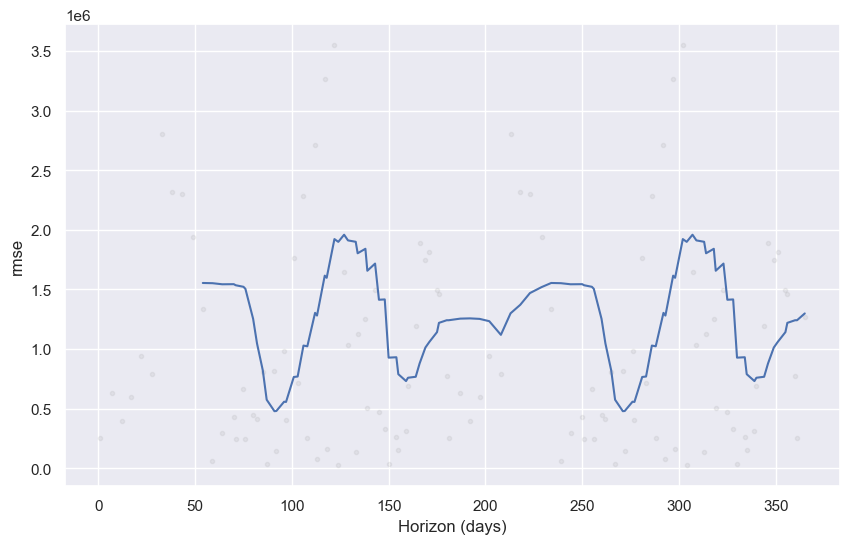

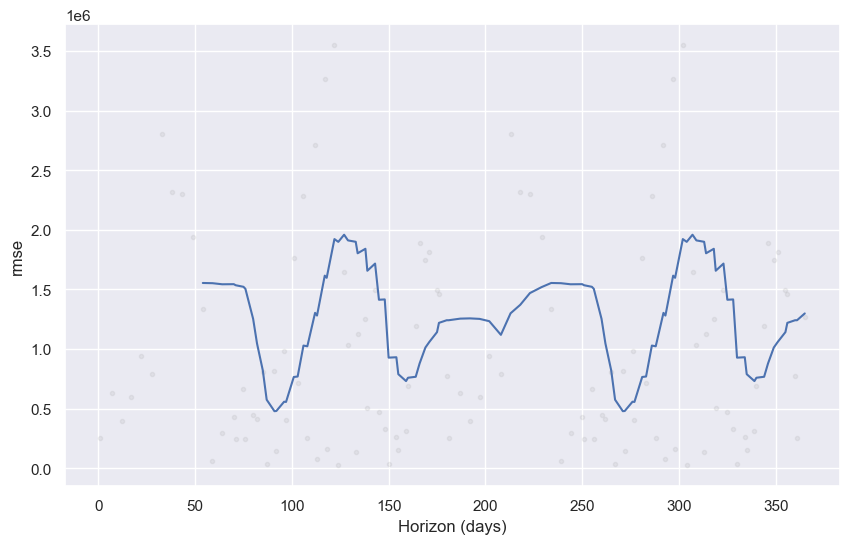

In \[232\]:

    plot_cross_validation_metric(df_cv, metric='mae')

Out\[232\]:

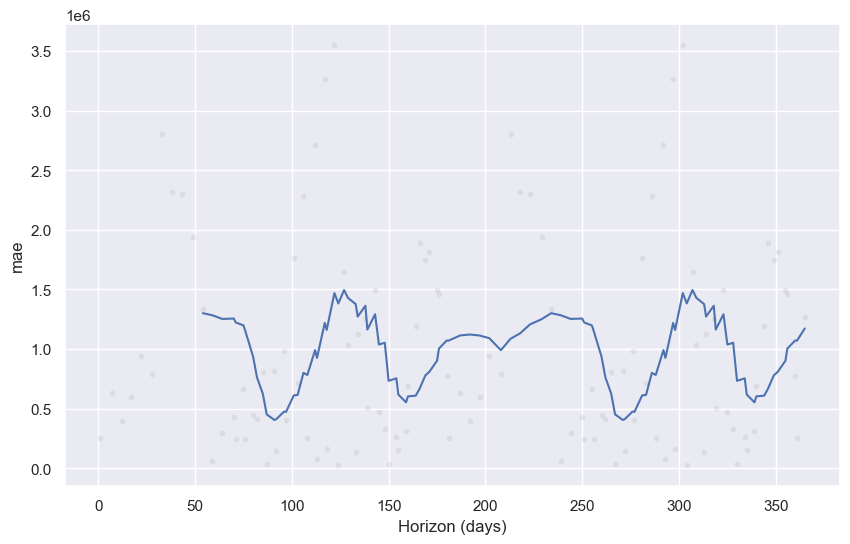

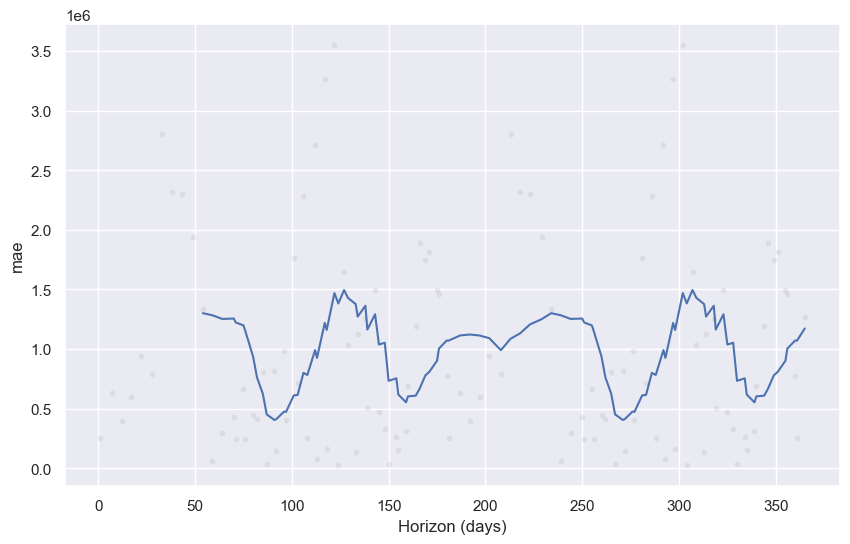

In \[233\]:

    plot_cross_validation_metric(df_cv, metric='mape')

Out\[233\]:

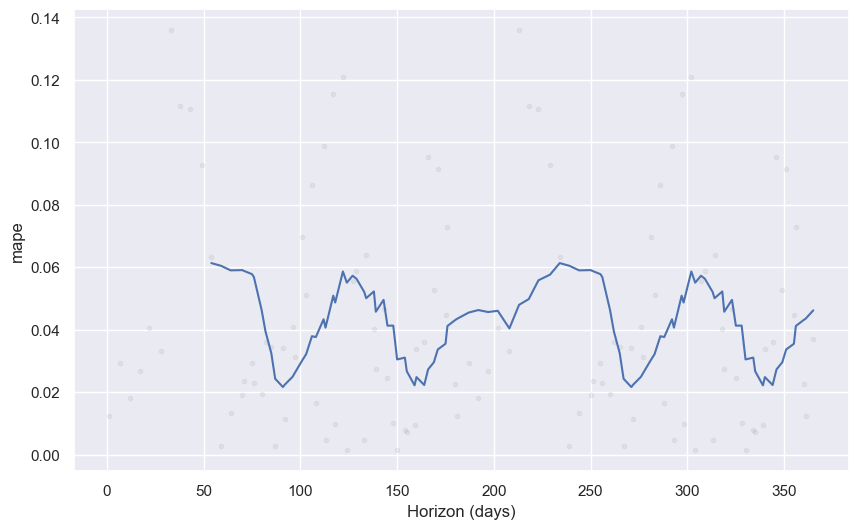

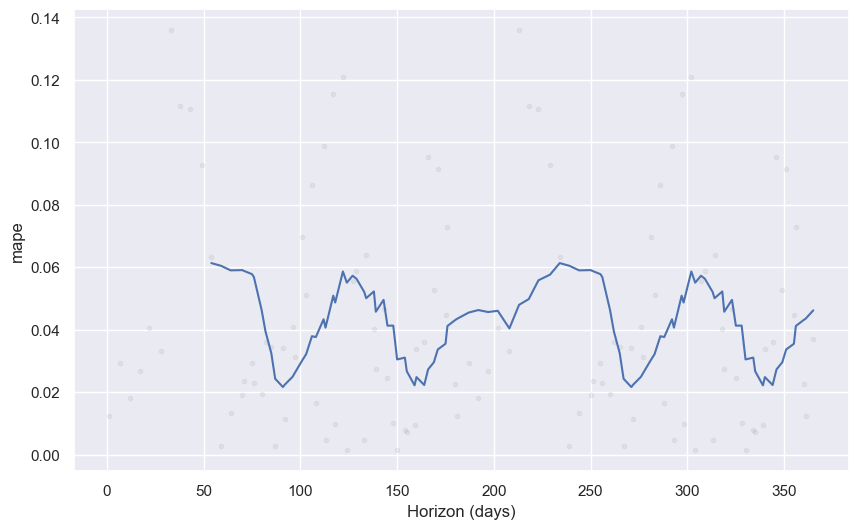

In \[ \]:

     

In \[ \]:

     

In \[ \]:

     

In \[ \]:

     

# Sea level change<a href="#Sea-level-change" class="anchor-link">¶</a>

In \[234\]:

    sea_pd = pd.read_csv('sea_levels_2015.csv')
    sea_pd['Time'] = pd.to_datetime(sea_pd['Time'], format="%Y/%m/%d")
    sea_pd = sea_pd.loc[(sea_pd['Time'] >= '1960-01-01') & (sea_pd['Time'] <= '2019-12-31')]
    sea_pd.head()

Out\[234\]:

|     | Time       | GMSL  | GMSL uncertainty |
|-----|------------|-------|------------------|
| 960 | 1960-01-15 | -48.9 | 6.6              |
| 961 | 1960-02-15 | -44.9 | 6.6              |
| 962 | 1960-03-15 | -45.1 | 6.6              |
| 963 | 1960-04-15 | -43.1 | 6.6              |
| 964 | 1960-05-15 | -42.5 | 6.6              |

In \[235\]:

    # Create traces
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = sea_pd['Time'] , y=sea_pd.GMSL, mode='lines', name='GMSL'))
    #fig.add_trace(go.Scatter(x = sea_pd['Time'] , y=sea_pd.line, line = dict(color='red', width=1, dash='dash'), name='Trend'))

    # adjusting size of graph, legend place, and background colour
    fig.update_layout(autosize=False, width=1000, height=600, margin=dict(l=50,r=50, b=100,t=100,pad=4),
        template='seaborn', title='Global Mean Sea Level changes', paper_bgcolor="rgb(234, 234, 242)",
        legend=dict(orientation="h", yanchor="bottom",y=1.02,xanchor="right", x=1))
    fig.update_xaxes(type='category',title='Years')
    fig.update_yaxes(title='Global Mean Sea Level (mm)')

    fig.show('notebook')

In \[236\]:

    ts=sea_pd.groupby(["Time"])["GMSL"].sum()

In \[237\]:

    ts = sea_pd.rename(columns={'Time':'ds', 'GMSL':'y','GMSL uncertainty':'yhat'})

    ts.columns=['ds','y','yhat']
    model1 = Prophet( yearly_seasonality=True) 
    model1.fit(ts)

    00:09:10 - cmdstanpy - INFO - Chain [1] start processing
    00:09:10 - cmdstanpy - INFO - Chain [1] done processing

Out\[237\]:

    <prophet.forecaster.Prophet at 0x15388f910>

In \[238\]:

    # predict for 1 year in the furure and MS - month start is the frequency
    future = model1.make_future_dataframe(periods = 444, freq = 'MS') 
    future.tail()

Out\[238\]:

|      | ds         |
|------|------------|
| 1087 | 2050-08-01 |
| 1088 | 2050-09-01 |
| 1089 | 2050-10-01 |
| 1090 | 2050-11-01 |
| 1091 | 2050-12-01 |

In \[239\]:

    # now lets make the forecasts
    forecast = model1.predict(future)
    forecast.tail()

Out\[239\]:

|      | ds         | trend      | yhat_lower | yhat_upper | trend_lower | trend_upper | additive_terms | additive_terms_lower | additive_terms_upper | yearly     | yearly_lower | yearly_upper | multiplicative_terms | multiplicative_terms_lower | multiplicative_terms_upper | yhat       |
|------|------------|------------|------------|------------|-------------|-------------|----------------|----------------------|----------------------|------------|--------------|--------------|----------------------|----------------------------|----------------------------|------------|
| 1087 | 2050-08-01 | 219.629618 | 195.112741 | 250.663533 | 191.263928  | 245.210170  | 4.880047       | 4.880047             | 4.880047             | 4.880047   | 4.880047     | 4.880047     | 0.0                  | 0.0                        | 0.0                        | 224.509665 |
| 1088 | 2050-09-01 | 219.966233 | 202.783910 | 257.425592 | 191.521937  | 245.606808  | 11.812785      | 11.812785            | 11.812785            | 11.812785  | 11.812785    | 11.812785    | 0.0                  | 0.0                        | 0.0                        | 231.779018 |
| 1089 | 2050-10-01 | 220.291990 | 194.371609 | 249.744197 | 191.774540  | 245.998627  | 3.272461       | 3.272461             | 3.272461             | 3.272461   | 3.272461     | 3.272461     | 0.0                  | 0.0                        | 0.0                        | 223.564451 |
| 1090 | 2050-11-01 | 220.628604 | 187.159152 | 243.578743 | 192.048011  | 246.407347  | -3.849131      | -3.849131            | -3.849131            | -3.849131  | -3.849131    | -3.849131    | 0.0                  | 0.0                        | 0.0                        | 216.779473 |
| 1091 | 2050-12-01 | 220.954361 | 180.715191 | 236.260323 | 192.316411  | 246.835055  | -11.293515     | -11.293515           | -11.293515           | -11.293515 | -11.293515   | -11.293515   | 0.0                  | 0.0                        | 0.0                        | 209.660845 |

In \[240\]:

    forecast.head()

Out\[240\]:

|     | ds         | trend      | yhat_lower | yhat_upper | trend_lower | trend_upper | additive_terms | additive_terms_lower | additive_terms_upper | yearly    | yearly_lower | yearly_upper | multiplicative_terms | multiplicative_terms_lower | multiplicative_terms_upper | yhat       |
|-----|------------|------------|------------|------------|-------------|-------------|----------------|----------------------|----------------------|-----------|--------------|--------------|----------------------|----------------------------|----------------------------|------------|
| 0   | 1960-01-15 | -47.612698 | -55.338371 | -41.237153 | -47.612698  | -47.612698  | -0.617279      | -0.617279            | -0.617279            | -0.617279 | -0.617279    | -0.617279    | 0.0                  | 0.0                        | 0.0                        | -48.229977 |
| 1   | 1960-02-15 | -47.545456 | -55.462295 | -40.950030 | -47.545456  | -47.545456  | -0.290799      | -0.290799            | -0.290799            | -0.290799 | -0.290799    | -0.290799    | 0.0                  | 0.0                        | 0.0                        | -47.836254 |
| 2   | 1960-03-15 | -47.482552 | -55.074663 | -40.554056 | -47.482552  | -47.482552  | -0.371233      | -0.371233            | -0.371233            | -0.371233 | -0.371233    | -0.371233    | 0.0                  | 0.0                        | 0.0                        | -47.853785 |
| 3   | 1960-04-15 | -47.415310 | -54.904377 | -40.519979 | -47.415310  | -47.415310  | 0.043208       | 0.043208             | 0.043208             | 0.043208  | 0.043208     | 0.043208     | 0.0                  | 0.0                        | 0.0                        | -47.372102 |
| 4   | 1960-05-15 | -47.350237 | -54.536069 | -39.356471 | -47.350237  | -47.350237  | 0.408130       | 0.408130             | 0.408130             | 0.408130  | 0.408130     | 0.408130     | 0.0                  | 0.0                        | 0.0                        | -46.942107 |

In \[241\]:

    model1.plot(forecast)

Out\[241\]:

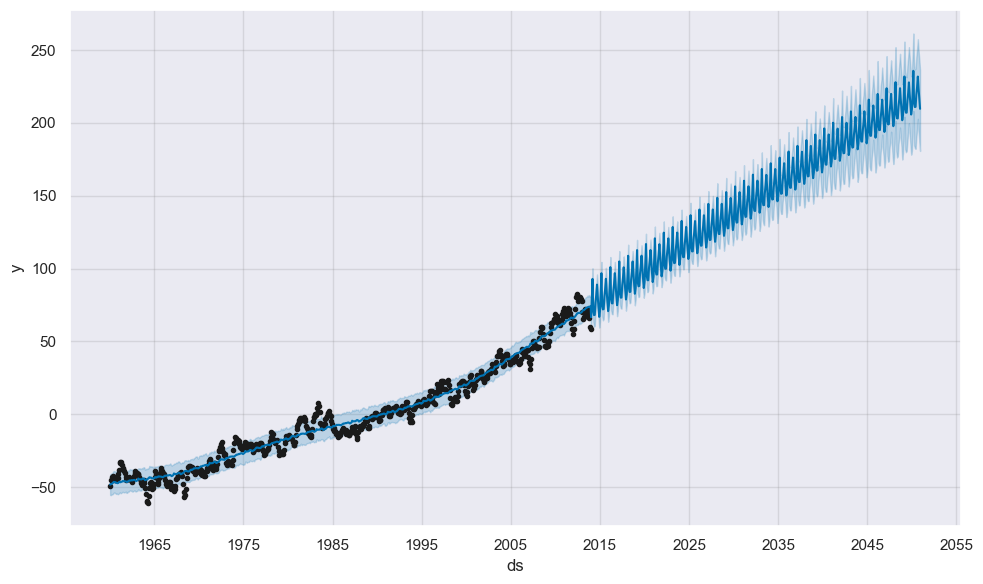

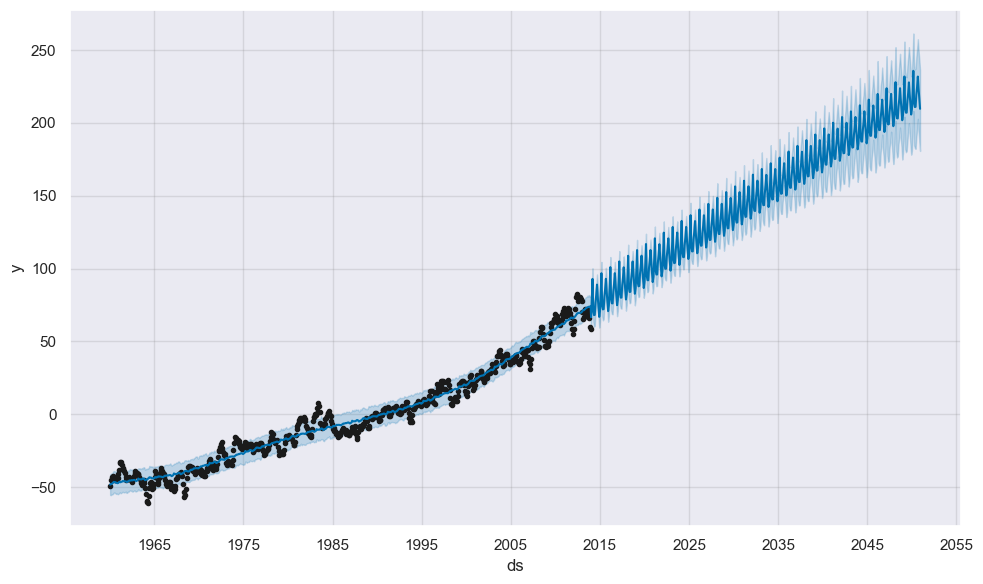

In \[244\]:

    df_cv = cross_validation(model1, initial='730 days', period='180 days', horizon = '365 days')

      0%|          | 0/104 [00:00<?, ?it/s]

    00:09:11 - cmdstanpy - INFO - Chain [1] start processing
    00:09:17 - cmdstanpy - INFO - Chain [1] done processing
    00:09:17 - cmdstanpy - INFO - Chain [1] start processing
    00:09:17 - cmdstanpy - INFO - Chain [1] done processing
    00:09:17 - cmdstanpy - INFO - Chain [1] start processing
    00:09:17 - cmdstanpy - INFO - Chain [1] done processing
    00:09:17 - cmdstanpy - INFO - Chain [1] start processing
    00:09:17 - cmdstanpy - INFO - Chain [1] done processing
    00:09:17 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:18 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:18 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:18 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:18 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:18 - cmdstanpy - INFO - Chain [1] start processing
    00:09:18 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:19 - cmdstanpy - INFO - Chain [1] done processing
    00:09:19 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:20 - cmdstanpy - INFO - Chain [1] done processing
    00:09:20 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:21 - cmdstanpy - INFO - Chain [1] done processing
    00:09:21 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:22 - cmdstanpy - INFO - Chain [1] start processing
    00:09:22 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:23 - cmdstanpy - INFO - Chain [1] done processing
    00:09:23 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:24 - cmdstanpy - INFO - Chain [1] start processing
    00:09:24 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing
    00:09:25 - cmdstanpy - INFO - Chain [1] start processing
    00:09:25 - cmdstanpy - INFO - Chain [1] done processing

In \[245\]:

    df_cv.head()

Out\[245\]:

|     | ds         | yhat       | yhat_lower | yhat_upper | y     | cutoff     |
|-----|------------|------------|------------|------------|-------|------------|
| 0   | 1962-03-15 | -40.634492 | -40.803489 | -40.435703 | -44.1 | 1962-03-13 |
| 1   | 1962-04-15 | -45.908039 | -46.420057 | -45.280025 | -44.6 | 1962-03-13 |
| 2   | 1962-05-15 | -51.670550 | -52.608106 | -50.461577 | -45.4 | 1962-03-13 |
| 3   | 1962-06-15 | -55.682967 | -57.239274 | -53.814497 | -45.1 | 1962-03-13 |
| 4   | 1962-07-15 | -56.358464 | -58.536608 | -53.697625 | -46.6 | 1962-03-13 |

In \[246\]:

    df_p = performance_metrics(df_cv)
    df_p.head()

Out\[246\]:

|     | horizon | mse       | rmse     | mae      | mdape    | smape    | coverage |
|-----|---------|-----------|----------|----------|----------|----------|----------|
| 0   | 37 days | 47.608001 | 6.899855 | 5.757335 | 0.226597 | 0.476291 | 0.625000 |
| 1   | 38 days | 47.978280 | 6.926636 | 5.771935 | 0.226597 | 0.486250 | 0.629032 |
| 2   | 39 days | 48.085070 | 6.934340 | 5.766684 | 0.220859 | 0.477309 | 0.629032 |
| 3   | 40 days | 48.466069 | 6.961758 | 5.823585 | 0.230476 | 0.482648 | 0.618280 |
| 4   | 41 days | 48.460874 | 6.961384 | 5.809885 | 0.230476 | 0.479929 | 0.616935 |

In \[247\]:

    df_p.tail()

Out\[247\]:

|     | horizon  | mse       | rmse     | mae      | mdape    | smape    | coverage |
|-----|----------|-----------|----------|----------|----------|----------|----------|
| 324 | 361 days | 65.271436 | 8.079074 | 6.653391 | 0.240987 | 0.518110 | 0.572581 |
| 325 | 362 days | 64.163743 | 8.010227 | 6.583705 | 0.228181 | 0.512906 | 0.569892 |
| 326 | 363 days | 63.713564 | 7.982078 | 6.585724 | 0.240987 | 0.529785 | 0.561828 |
| 327 | 364 days | 63.880574 | 7.992532 | 6.590234 | 0.228181 | 0.529507 | 0.560484 |
| 328 | 365 days | 68.449301 | 8.273409 | 6.839334 | 0.243107 | 0.539219 | 0.546371 |

In \[248\]:

    plot_cross_validation_metric(df_cv, metric='rmse')

Out\[248\]:

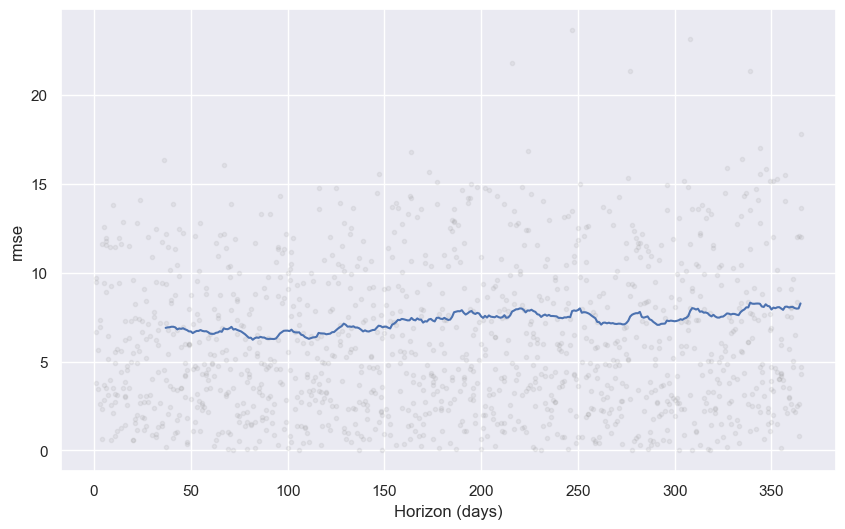

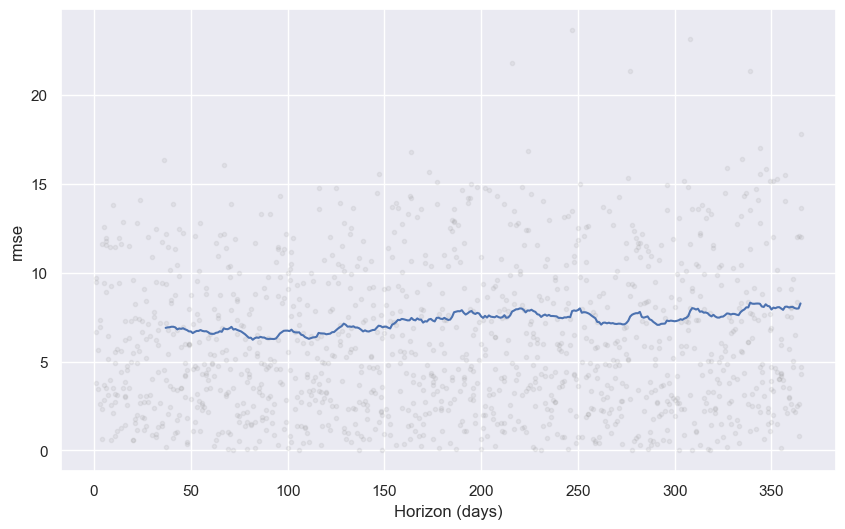

In \[249\]:

    plot_cross_validation_metric(df_cv, metric='mae')

Out\[249\]:

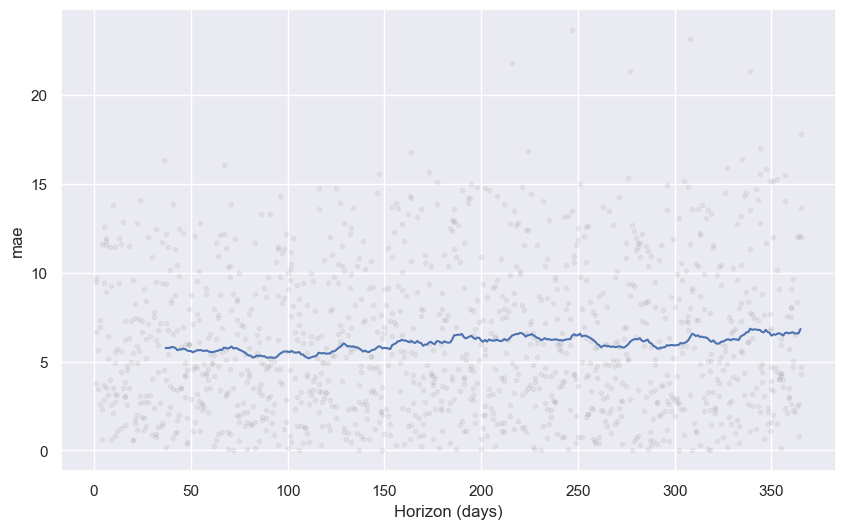

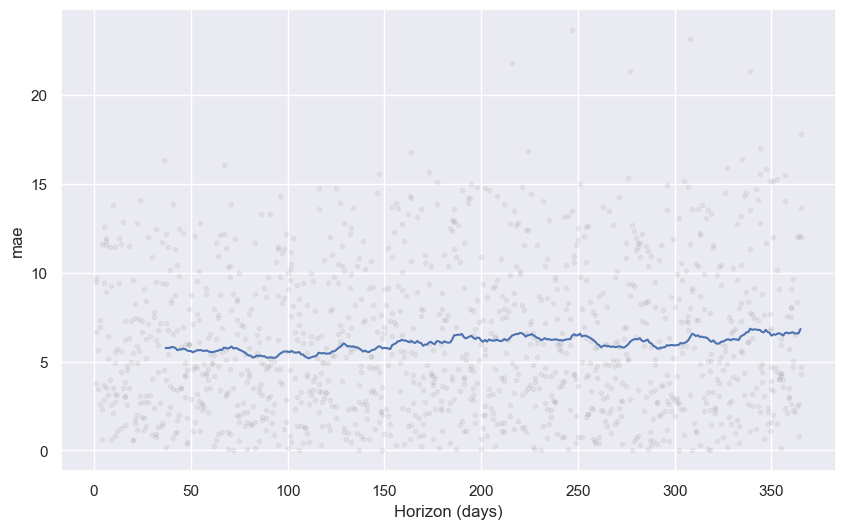

In \[ \]:

     

In \[ \]: